## Learning How to Make Generative Adversarial Networks (GANs)

What are Generative Adversarial Networks (GANs) in the first place? It's a neural network that can make (generate) new data that is similar to the training set. The way GANs work is that they use 2 neural networks that work against each other, the generator and the discriminator. The generator will work towards creating the new data and the discriminator will aim to differentiating the new data as 'real' or 'fake' in accordance to the training set. It's how people generate deep fakes nowadays. By training the generator model on the real person, it can create an image exactly like or almost like the real image and how the image is judged as being the same or not is determined by the discriminator model. 

In a similar vein, we will try to create a GAN where it takes a photo and tries to remake it in 'Monet' form. The images will be provided by Kaggle ([here](https://www.kaggle.com/competitions/gan-getting-started/overview)). The data set consists of around 7000 photos and 300 Monet images. The images are RGB, so they have 3 channels, and are sized 
(256 x 256) px.

## Resources
- https://www.tensorflow.org/tutorials/generative/dcgan
- https://www.tensorflow.org/tutorials/generative/pix2pix
- https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook 

## Exploratory

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shutil
import PIL
import os
import tensorflow as tf

from tensorflow.keras import layers

The data provided by Kaggle can be found in 4 folders, 2 of them have jpeg images whereas the other 2 are tfrecords. We will be using the tfrecord files for this notebook.

In [2]:
# Checking the files in the folders holing the .tfrec files.
MONET_FILES= tf.io.gfile.glob(str('./monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILES))

PHOTO_FILES = tf.io.gfile.glob(str('./photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [3]:
# Checking an example file
raw_dataset = tf.data.TFRecordDataset("monet_tfrec/monet00-60.tfrec")

for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    #print(example)

Because there's a lot of text and it takes a lot of space, this is an simplification of what a single record would look like in the tfrecord file.

    features {
        feature {
        key: "target"
        value {
          bytes_list {
            value: "monet"
          }
        }
      }
  
        feature {
        key: "image"
        value {
          bytes_list {
            value: "lots of numbers and characters"
          }
        }
      }
  
        feature {
        key: "image_name"
        value {
          bytes_list {
            value: "25c9904782"
          }
        }
      }
    }
    
The 'target' feature shows what type of photo it is, the image feature holds the values representing the image, and the 'image_name' is just what the file name would be in the jpeg image folder. 

So the next steps would be to read the record file and decode the image from the 'image' feature. The other 2 features are unnecessary because we are building a generative model not a classification model. We are also going to scale the image between [-1, 1]. Then we are going to make our photo datasets.

In [4]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    # scaling the image to [-1, 1]
    image = (image / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])

    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    # working only with the 'image' feature
    image = decode_image(example['image'])
    return image

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

# creating the dataset
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames) # read .tfrec files
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE) # decode them into image sets
    return dataset

In [6]:
monet_ds = load_dataset(MONET_FILES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILES, labeled=True).batch(1)

In [7]:
# checking the first image in both sets
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

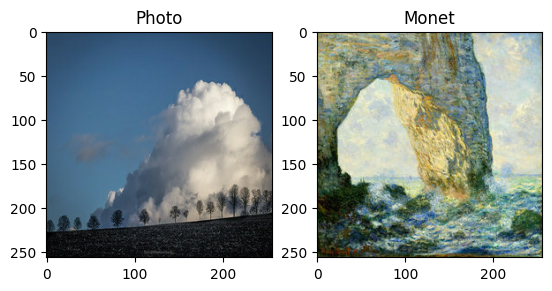

In [8]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0]*0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0]*0.5 + 0.5)

plt.show()

We can confirm that the images are RGB images and have size of 256 x 256 px. We see that the Monet image looks very artistic compared to the real image on the left. To reiterate, creating a Monet version of the real photo is going to be our goal.

## Model

The GAN model we will be creating is going to be a CycleGan. A CycleGan model follows the same principle of the original GAN model however the difference is that there are 2 generator models and 2 discriminator models in comparison to 1 each. The 2 generator/discriminator models are going to be used to create real and 'Monet' images. The 2 discriminator models will thus determine whether a photo can be considered 'real' or fake and 'monet' or fake. The CycleGAN model will work much like in an unsupervised manner where there is no pairing of images for comparison, i.e. if we take the cloud example above, we are not going to comparing it with a 'Monet' version of it so it can learn how to create Monet images. It's more close to studying a collection of images, creating an image, determining whether it fits the criteria of what makes a image 'real' or 'Monet'. This process is iterated through and eventually the model will learn how to take a real image and transform it into a Monet image.

Following the CycleGAN tutorial, found in the resources above, the model architecture is going to be a UNet architecture. The UNet architecture is U-shaped so it's symmetrical. Moving down the U, the model is similar to any other Convolutional Neural Network (CNN) and is downsampling the image. Each layer is concatenated with the layers on the other side of the U. This part is the upsampling part where you use Convolutional transpose layers instead. By concatenating the similar layers, they are able to compare each pixel from the layers. This architecture would be our generator model. In a sense, this generator would downsize the real photo into a much smaller image, and then upscale it into a Monet image. Whether the result is Monet or not is determined by the discriminator models.

The discriminator model is going to be like other CNNs where it uses convolutional 2D layers and will aim to classify whether the input image from the generator is Monet or fake, or real or fake.

This model architecture is widely used, and was initially made for biomedical imaging so it should be worth the shot.

The downsampling method is taking an input and then it adds convolutional 2D layer -> batchnormalization(conditional) -> leaky ReLU activation layer

In [9]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    
    result.add(layers.LeakyReLU())

    return result

The upsampling method is going to take the input, given that the input before it is going to be the same dimension, add a convolutional 2D transpose layer -> batchnormalization -> dropout(conditional) -> leaky ReLu activation layer. 

In [10]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    
    result.add(layers.BatchNormalization())
    
    if apply_dropout:
        result.add(layers.Dropout(0.2))

    result.add(layers.ReLU())

    return result

In [11]:
def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [12]:
generator = Generator()

Taking a look at an untrained generator model, we see it produces just a gray image.

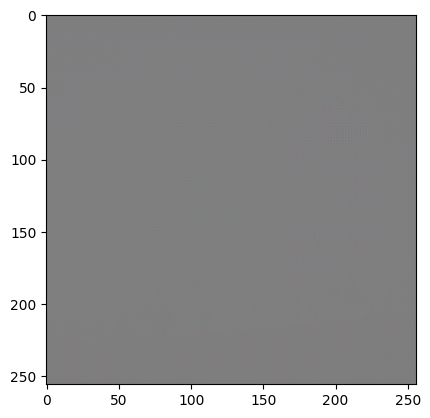

In [13]:
gen_output = generator(example_photo)
plt.imshow(gen_output[0] * 0.5 + 0.5)
plt.show()

In [14]:
LAMBDA = 100

Next we have to define the loss function of the generator. The loss function is going to compare the generated images with arrays of 1s. Where the 1 would equal a plausible image from the generator. Therefore, the generator loss function will try to minimize the loss.

Do note however that we have 2 generators therefore there is going to be 2 generator loss functions, 1 for the monet generator and 1 for the real image generator. The same will apply for the discriminator (loss) as well. The model will ultimately by trying to find a balance between the loss in the generators and the discriminators.

In [15]:
def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, 
                                             reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [16]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    target = layers.Input(shape=[256, 256, 3], name='target_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    
    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)
    
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [17]:
discriminator = Discriminator()

This is just putting the generated image from earlier (the gray image) into the discriminator and seeing what it puts out. We see that its a mess. But if we knew the real photo beforehand, we can sort of see the outline of the big cloud.

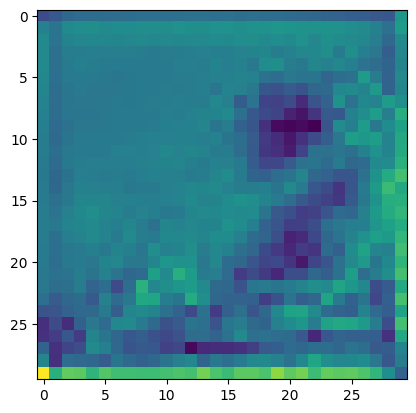

In [18]:
disc_out = discriminator(gen_output)
plt.imshow(disc_out[0])
plt.show()

In [19]:
def discriminator_loss(disc_real_output, disc_gen_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, 
                                                   reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(disc_real_output), disc_real_output)
    gen_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                  reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(disc_gen_output), disc_gen_output)
    
    total_loss = real_loss + gen_loss
    return total_loss * 0.5

The identity loss compares the input image with the output image of the generator. This is to ensure that the image coming out and at least like what it was originally.

In [20]:
def identity_loss(real, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real - same_image))
    return LAMBDA * 0.5 *loss

The cycle loss is the loss in comparing the real image with the monet image of itself. The loss will aim towards making the the 2 images similar to each other. 

In [21]:
def cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

In [22]:
# takes input image and shows what the generator spits out for it.
def generate_image(model, test_input):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(12, 12))
    
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
    
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

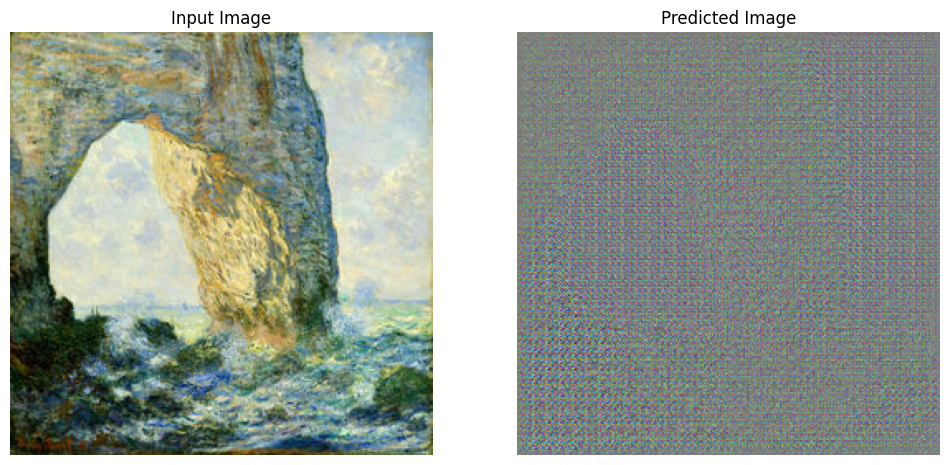

In [23]:
for sample_image in monet_ds.take(1):
    generate_image(generator, sample_image)

Overall with the untrained generator, you can't see much of anything in the predicted image. However, looking closely we do see that the predicted images shows slight outlines of the original image, especially the curved rock cliff.

We have pretty much everything set up, so we just have to put it together to make the CycleGAN model.

In [24]:
class CycleGan(tf.keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle = 10
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
    
    def compile(
        self, 
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_func,
        disc_loss_func,
        cycle_loss_func,
        identity_loss_func
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        
        self.gen_loss_func = gen_loss_func
        self.disc_loss_func = disc_loss_func
        self.cycle_loss_func = cycle_loss_func
        self.identity_loss_func = identity_loss_func
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent = True) as tape:
            # photo -> monet -> photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)
            
            # monet -> photo -> monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)
            
            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)
            
            # discriminator checking real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            
            # discriminator checking fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
            
            # evaluate generator loss
            monet_gen_loss = self.gen_loss_func(disc_fake_monet)
            photo_gen_loss = self.gen_loss_func(disc_fake_photo)
            
            # evalutate total cycle consistency loss
            total_cycle_loss = self.cycle_loss_func(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_func(real_photo, cycled_photo, self.lambda_cycle)
            
            # evaluate total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_func(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_func(real_photo, same_photo, self.lambda_cycle)
            
            # evaluate discriminator loss
            monet_disc_loss = self.disc_loss_func(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_func(disc_real_photo, disc_fake_photo)
            
        # calculate gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)
            
        # apply gradient to optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        # this is what you will see during the training
        return {
            'monet_gen_loss': total_monet_gen_loss,
            'photo_gen_loss': total_photo_gen_loss,
            'monet_disc_loss': monet_disc_loss,
            'photo_disc_loss': photo_disc_loss
        }

In [25]:
# selecting the Adam optimizer for each generator/discriminator
# beta_1 is the exponential decay for the first moment. Is 0.9 by default but set to 0.5
# for a smoother decay.
monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Train the Model

In [26]:
monet_generator = Generator()
photo_generator = Generator()
monet_disc = Discriminator()
photo_disc = Discriminator()

cycle_gan_model = CycleGan(
    monet_generator, photo_generator, monet_disc, photo_disc)

cycle_gan_model.compile(m_gen_optimizer = monet_generator_optimizer,
                       p_gen_optimizer = photo_generator_optimizer,
                       m_disc_optimizer = monet_discriminator_optimizer,
                       p_disc_optimizer = photo_discriminator_optimizer,
                       gen_loss_func=generator_loss,
                       disc_loss_func=discriminator_loss,
                       cycle_loss_func=cycle_loss,
                       identity_loss_func=identity_loss
                       )

In [27]:
history1 = cycle_gan_model.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), epochs=25)

Epoch 1/25
300/300 [==============================] - 108s 336ms/step - monet_gen_loss: 5.3102 - photo_gen_loss: 5.4015 - monet_disc_loss: 0.6928 - photo_disc_loss: 0.6973
Epoch 2/25
300/300 [==============================] - 100s 333ms/step - monet_gen_loss: 3.6857 - photo_gen_loss: 3.6818 - monet_disc_loss: 0.6554 - photo_disc_loss: 0.6656
Epoch 3/25
300/300 [==============================] - 100s 333ms/step - monet_gen_loss: 3.4344 - photo_gen_loss: 3.4497 - monet_disc_loss: 0.6525 - photo_disc_loss: 0.6575
Epoch 4/25
300/300 [==============================] - 100s 334ms/step - monet_gen_loss: 3.2911 - photo_gen_loss: 3.3172 - monet_disc_loss: 0.6481 - photo_disc_loss: 0.6514
Epoch 5/25
300/300 [==============================] - 100s 334ms/step - monet_gen_loss: 3.1670 - photo_gen_loss: 3.1953 - monet_disc_loss: 0.6442 - photo_disc_loss: 0.6459
Epoch 6/25
300/300 [==============================] - 100s 334ms/step - monet_gen_loss: 3.0421 - photo_gen_loss: 3.0762 - monet_disc_loss: 0

In [28]:
def compare_results(generator, model_num):
    fig, ax = plt.subplots(3, 2, figsize=(12, 12))
    
    for i, img in enumerate(photo_ds.take(3)):
        prediction = generator(img, training=True)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
        
        ax[i, 0].imshow(img)
        ax[i, 1].imshow(prediction)
        
        ax[i, 0].set_title('Real Photo')
        ax[i, 1].set_title('Generated Monet')
    
    plt.suptitle(f'Model {model_num}')
    plt.show()

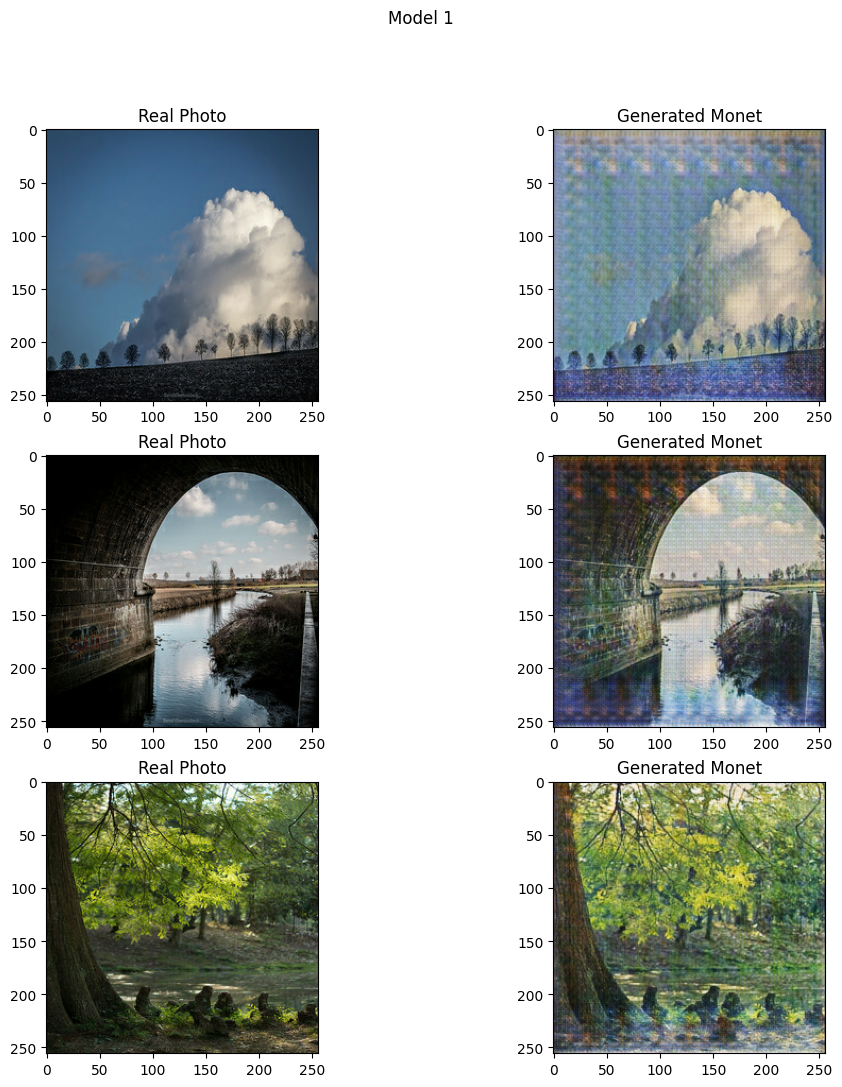

In [29]:
compare_results(monet_generator, 1)

Looks pretty good actually!

In [30]:
def make_submission(generator, model_num):
    # make directory for predicted monet images
    os.mkdir(f'./images{model_num}')
    
    # generate images and name them
    i = 1
    for img in photo_ds:
        prediction = generator(img, training=True)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        img = PIL.Image.fromarray(prediction)
        img.save(f"./images{model_num}/" + str(i) + ".jpg")
        i = i + 1
    
    # make zip file of images
    shutil.make_archive(f'prediction_images{model_num}', 'zip', f"./images{model_num}")

In [31]:
make_submission(monet_generator, 1)

## Comparing other Models

Below is just comparing with other models.

The second model is one where we keep the beta_1 value to it's default value.

The third model is one where we change the learning rate to 2e-3 instead of 2e-4.

In [32]:
monet_generator2 = Generator()
photo_generator2 = Generator()
monet_disc2 = Discriminator()
photo_disc2 = Discriminator()

monet_generator_optimizer2 = tf.keras.optimizers.Adam(2e-4)
photo_generator_optimizer2 = tf.keras.optimizers.Adam(2e-4)

monet_discriminator_optimizer2 = tf.keras.optimizers.Adam(2e-4)
photo_discriminator_optimizer2 = tf.keras.optimizers.Adam(2e-4)

cycle_gan_model2 = CycleGan(
    monet_generator2, photo_generator2, monet_disc2, photo_disc2)

cycle_gan_model2.compile(m_gen_optimizer = monet_generator_optimizer2,
                       p_gen_optimizer = photo_generator_optimizer2,
                       m_disc_optimizer = monet_discriminator_optimizer2,
                       p_disc_optimizer = photo_discriminator_optimizer2,
                       gen_loss_func=generator_loss,
                       disc_loss_func=discriminator_loss,
                       cycle_loss_func=cycle_loss,
                       identity_loss_func=identity_loss
                       )

In [33]:
history2 = cycle_gan_model2.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), epochs=25)

Epoch 1/25
300/300 [==============================] - 107s 334ms/step - monet_gen_loss: 5.4786 - photo_gen_loss: 5.5955 - monet_disc_loss: 0.6897 - photo_disc_loss: 0.6888
Epoch 2/25
300/300 [==============================] - 100s 334ms/step - monet_gen_loss: 3.6686 - photo_gen_loss: 3.6846 - monet_disc_loss: 0.6553 - photo_disc_loss: 0.6605
Epoch 3/25
300/300 [==============================] - 100s 334ms/step - monet_gen_loss: 3.4556 - photo_gen_loss: 3.4889 - monet_disc_loss: 0.6532 - photo_disc_loss: 0.6556
Epoch 4/25
300/300 [==============================] - 100s 334ms/step - monet_gen_loss: 3.2891 - photo_gen_loss: 3.3381 - monet_disc_loss: 0.6496 - photo_disc_loss: 0.6488
Epoch 5/25
300/300 [==============================] - 100s 334ms/step - monet_gen_loss: 3.1576 - photo_gen_loss: 3.2075 - monet_disc_loss: 0.6458 - photo_disc_loss: 0.6446
Epoch 6/25
300/300 [==============================] - 100s 334ms/step - monet_gen_loss: 3.0212 - photo_gen_loss: 3.0834 - monet_disc_loss: 0

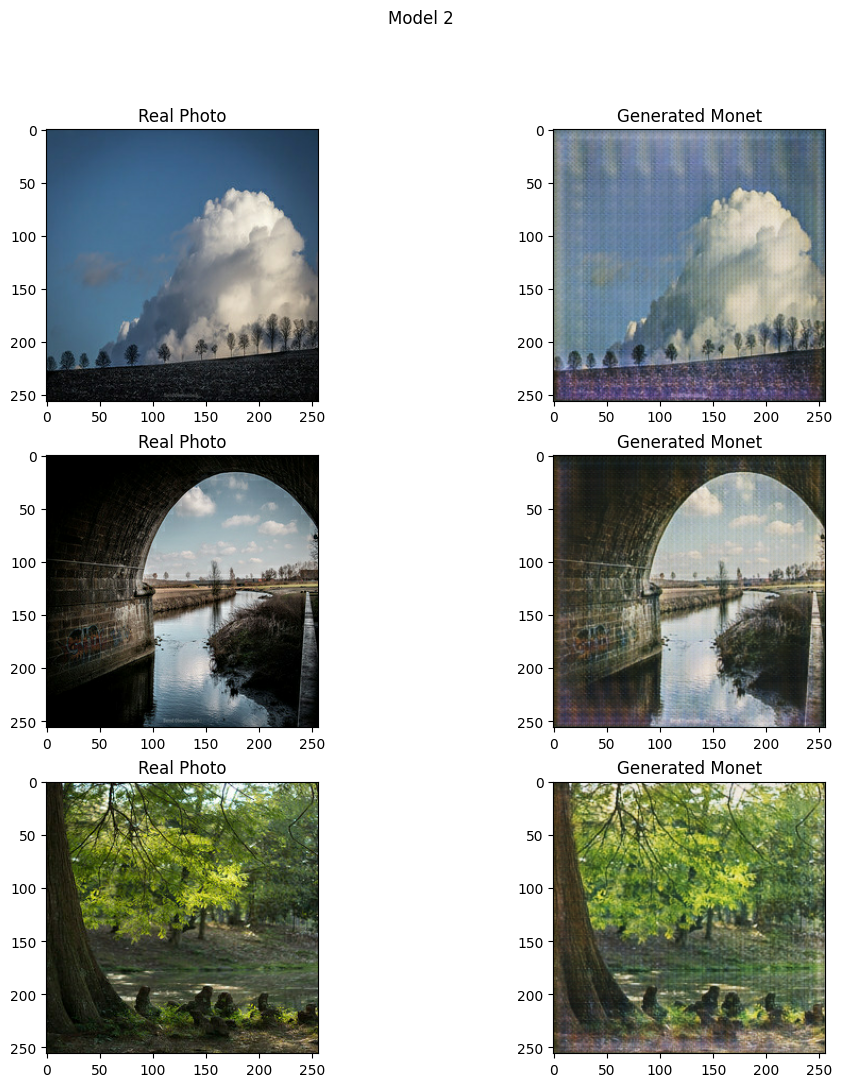

In [34]:
compare_results(monet_generator2, 2)

In [35]:
# make_submission(monet_generator2, 2)

In [36]:
monet_generator3 = Generator()
photo_generator3 = Generator()
monet_disc3 = Discriminator()
photo_disc3 = Discriminator()

monet_generator_optimizer3 = tf.keras.optimizers.Adam(2e-3)
photo_generator_optimizer3 = tf.keras.optimizers.Adam(2e-3)

monet_discriminator_optimizer3 = tf.keras.optimizers.Adam(2e-3)
photo_discriminator_optimizer3 = tf.keras.optimizers.Adam(2e-3)

cycle_gan_model3 = CycleGan(
    monet_generator3, photo_generator3, monet_disc3, photo_disc3)

cycle_gan_model3.compile(m_gen_optimizer = monet_generator_optimizer3,
                       p_gen_optimizer = photo_generator_optimizer3,
                       m_disc_optimizer = monet_discriminator_optimizer3,
                       p_disc_optimizer = photo_discriminator_optimizer3,
                       gen_loss_func=generator_loss,
                       disc_loss_func=discriminator_loss,
                       cycle_loss_func=cycle_loss,
                       identity_loss_func=identity_loss
                       )

In [37]:
history3 = cycle_gan_model3.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), epochs=25)

Epoch 1/25
300/300 [==============================] - 107s 334ms/step - monet_gen_loss: 4.1479 - photo_gen_loss: 4.2805 - monet_disc_loss: 0.7834 - photo_disc_loss: 0.7671
Epoch 2/25
300/300 [==============================] - 100s 335ms/step - monet_gen_loss: 2.9977 - photo_gen_loss: 3.0836 - monet_disc_loss: 0.7061 - photo_disc_loss: 0.7036
Epoch 3/25
300/300 [==============================] - 100s 335ms/step - monet_gen_loss: 2.8066 - photo_gen_loss: 2.8770 - monet_disc_loss: 0.7050 - photo_disc_loss: 0.6953
Epoch 4/25
300/300 [==============================] - 100s 335ms/step - monet_gen_loss: 2.7030 - photo_gen_loss: 2.7500 - monet_disc_loss: 0.6925 - photo_disc_loss: 0.6875
Epoch 5/25
300/300 [==============================] - 100s 335ms/step - monet_gen_loss: 2.6524 - photo_gen_loss: 2.6937 - monet_disc_loss: 0.6843 - photo_disc_loss: 0.6772
Epoch 6/25
300/300 [==============================] - 100s 334ms/step - monet_gen_loss: 2.5681 - photo_gen_loss: 2.6471 - monet_disc_loss: 0

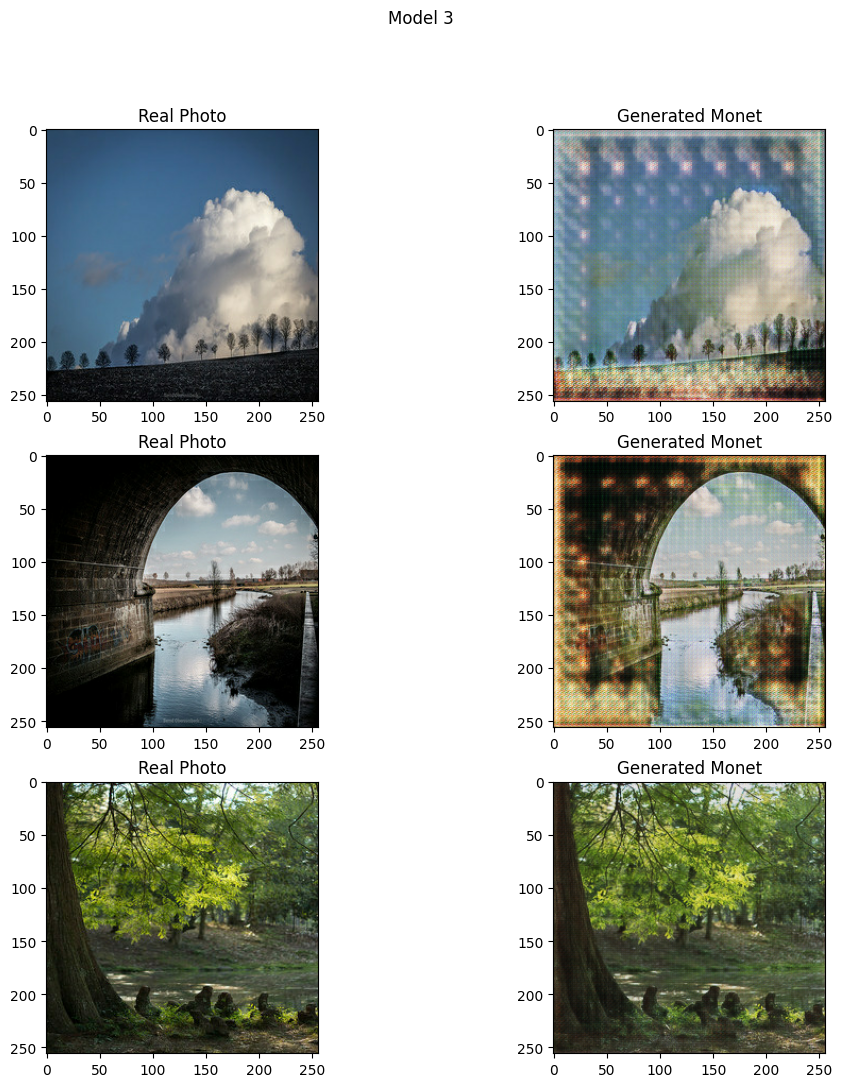

In [38]:
compare_results(monet_generator3, 3)

This one definitely looks more "glossy" compared to the other models.

In [39]:
# make_submission(monet_generator3, 3)

## Summary

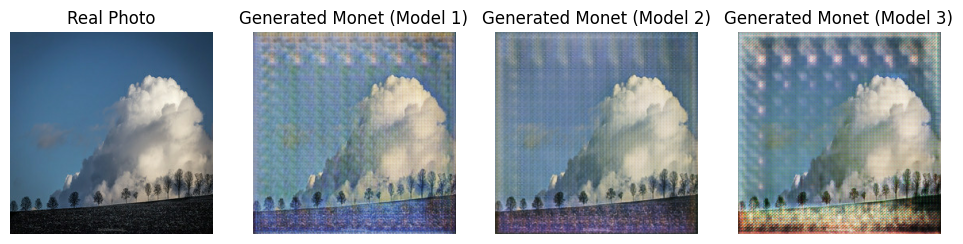

In [50]:
fig, ax = plt.subplots(1, 4, figsize=(12, 12))

img = photo_ds.take(1)
img = next(iter(img))

prediction = monet_generator(img, training=True)[0].numpy()
prediction = (prediction * 127.5 + 127.5).astype(np.uint8)

prediction2 = monet_generator2(img, training=True)[0].numpy()
prediction2 = (prediction2 * 127.5 + 127.5).astype(np.uint8)

prediction3 = monet_generator3(img, training=True)[0].numpy()
prediction3 = (prediction3 * 127.5 + 127.5).astype(np.uint8)

img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

ax[0].imshow(img)
ax[1].imshow(prediction)
ax[2].imshow(prediction2)
ax[3].imshow(prediction3)

ax[0].set_title('Real Photo')
ax[1].set_title('Generated Monet (Model 1)')
ax[2].set_title('Generated Monet (Model 2)')
ax[3].set_title('Generated Monet (Model 3)')

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')

plt.show()

We see that the second model actually looks more clean compared to the first model whereas the 3rd model looks to be more glossy in comparison. The model that looks more realistic is the second model. The one that looks more 'Monet' would probably by the first model. The first instead of the third because the third is differs in the color, i.e. the ground is more reddish brown than the others.

After submitting the first model, the result came out to be 59.78. The scoring is that the lower the score, the better the result. Comparing this score against the other people on the leaderboard, it's not exactly a top score but a passing one which is good enough for this assignment. (I also wanted to check the scoring of the other models but it takes too long to submit a whole notebook to the Kaggle competition since that's the only method they accept for their submission)

As for why these images differ, I think it's best to look back at what changed between the models. All 3 had the same model architecture, namely UNet, for the generator and the same architecture for the discriminators. The difference lies in the parameters in the optimizer. For model 1, the learning rate was set to be 2e-4 with a beta_1 value of 0.5. The beta_1 value is lowered from its default value of 0.9 for a smoother moment (change between epoch) decay, i.e. a slower decay. Model 2 uses the default beta_1 value of 0.9 with the same learning rate. Due to the higher beta_1 value it learns a little faster in comparison making the image more clear. Model 3 however used the default beta_1 value and increased the learning rate to 2e-3. As seen in the summary image above, it looks worst than the other 2 model possibly due to learning too quickly and moving past the optimal point (the local/global minimum).

## Discussion

Currently, the model is just training over a certain number of epochs. The loss functions are in a sense competing with each other and trying to balance and finding the even ground for all 4 loss functions. I think for better or worse, for the generate Monet image to look 'Monet', we can try to focus on having a low monet_gen_loss (generator) as well as a low monet_disc_loss (discriminator) value because those are what determines an image is 'Monet' or not. So, in a future work, we can try to focus on that. Perhaps even utilize tensorflow's callback functions to monitor the loss for those values and stop training when they are at the lowest.

## Conclusion

Overall, the CycleGAN model works pretty well in recreating an image into it's 'Monet' version albeit it looking slightly funky. The resulting score for the submitted model is 59.78 which is a decent score. It would have been nice to submit and examine the scores for the other models however that takes too much time, so we can only infer based on the generated images. 